In [2]:
import os, glob, pandas as pd

BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"
c1 = os.path.join(BASE, "c1")

print("c1 exists:", os.path.isdir(c1))
print("Top-level files in c1:")
for p in sorted(os.listdir(c1))[:30]:
    print("  ", p)


c1 exists: True
Top-level files in c1:
   c1
   c1_wear.csv


In [3]:
import re

# try to locate the wear file
candidates = []
for pat in ["*wear*.csv", "*wear*.txt", "*.csv", "*.txt"]:
    candidates += glob.glob(os.path.join(c1, pat))

# keep only those that look small (wear files are tiny vs. cut CSVs)
candidates = [p for p in candidates if os.path.getsize(p) < 2_000_000]  # < ~2MB
print("\nWear-file candidates:")
for p in candidates:
    print(" ", os.path.basename(p), os.path.getsize(p), "bytes")

if not candidates:
    raise FileNotFoundError("Couldn't find a small wear file in c1. Show me the file listing printed above.")

wear_file = candidates[0]  # pick the first small file
print("\nUsing wear file:", wear_file)

# robust read
df = pd.read_csv(
    wear_file,
    sep=None,                # let pandas infer delimiter
    engine="python",
    header=None,             # wear files often have no header
    comment="#"              # ignore commented lines if any
)

# drop columns that are completely empty
df = df.dropna(axis=1, how="all")

print("\nRaw wear file shape:", df.shape)
print("First 5 rows (raw):")
print(df.head())

# Keep only first two columns that look numeric; if strings like "Cut 1" appear, extract numbers
def to_numeric_series(s):
    if s.dtype.kind in "iufc":
        return s
    # try to pull numbers out of strings like "cut 12"
    return pd.to_numeric(s.astype(str).str.extract(r"(-?\d+\.?\d*)", expand=False), errors="coerce")

numeric_cols = []
for col in df.columns:
    col_series = to_numeric_series(df[col])
    # numeric if at least half are numbers
    if col_series.notna().mean() > 0.5:
        numeric_cols.append(col)

if len(numeric_cols) < 2:
    raise ValueError("Couldn't identify two numeric columns in wear file. Show me the head() above.")

df2 = df[numeric_cols[:2]].copy()
df2.columns = ["Cut_Number", "Wear_(0.001mm)"]

# final cleaning: integer cuts, float wear
df2["Cut_Number"] = pd.to_numeric(df2["Cut_Number"], errors="coerce").astype("Int64")
df2["Wear_(0.001mm)"] = pd.to_numeric(df2["Wear_(0.001mm)"], errors="coerce").astype("float64")
df2 = df2.dropna()

print("\nParsed wear table:")
print(df2.head(10))
print("Total cuts reported in wear file:", len(df2))



Wear-file candidates:
  c1_wear.csv 12749 bytes
  c1_wear.csv 12749 bytes

Using wear file: E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling\c1\c1_wear.csv

Raw wear file shape: (316, 4)
First 5 rows (raw):
     0            1            2            3
0  cut      flute_1      flute_2      flute_3
1    1  32.31711361  48.89261732  37.72082548
2    2    37.914879  49.57081504  37.72082548
3    3  43.08790971  50.30286727  37.72082548
4    4   47.8590723  51.08365203  37.84985103

Parsed wear table:
    Cut_Number  Wear_(0.001mm)
1            1       32.317114
2            2       37.914879
3            3       43.087910
4            4       47.859072
5            5       52.250329
6            6       56.282766
7            7       59.976616
8            8       63.351288
9            9       66.425391
10          10       69.216757
Total cuts reported in wear file: 315


In [4]:
# find a likely cut file (large CSV with many rows)
all_csvs = glob.glob(os.path.join(c1, "**", "*.csv"), recursive=True)

# exclude the wear file we just used
all_csvs = [p for p in all_csvs if os.path.abspath(p) != os.path.abspath(wear_file)]

# sort by size descending to prefer a real signal file
all_csvs = sorted(all_csvs, key=os.path.getsize, reverse=True)

print("\nTop 5 largest CSVs in c1 (likely cut files):")
for p in all_csvs[:5]:
    print(" ", os.path.relpath(p, c1), "|", os.path.getsize(p), "bytes")

if not all_csvs:
    raise FileNotFoundError("No cut CSVs found. Show me the directory listing.")

cut_path = all_csvs[0]
print("\nUsing cut file:", cut_path)

# read the cut file; drop empty columns; keep first 7 columns
cut = pd.read_csv(cut_path, header=None, engine="c", low_memory=False)
cut = cut.dropna(axis=1, how="all")

# Sometimes there can be extra trailing blank columns; we only need 7 channels
if cut.shape[1] < 7:
    print("WARNING: fewer than 7 columns found. Showing shape:", cut.shape)
else:
    cut = cut.iloc[:, :7]

cut.columns = ["Force_X", "Force_Y", "Force_Z", "Vib_X", "Vib_Y", "Vib_Z", "AE_RMS"]

print("\nCut file shape:", cut.shape)
print("First 5 rows of this cut:")
print(cut.head())

print("\nBasic stats (first cut we loaded):")
print(cut.describe().T[["mean","std","min","max"]])



Top 5 largest CSVs in c1 (likely cut files):
  c1\c_1_305.csv | 11710169 bytes
  c1\c_1_309.csv | 11699920 bytes
  c1\c_1_315.csv | 11584594 bytes
  c1\c_1_308.csv | 10638246 bytes
  c1\c_1_304.csv | 10556513 bytes

Using cut file: E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling\c1\c1\c_1_305.csv

Cut file shape: (254944, 7)
First 5 rows of this cut:
   Force_X  Force_Y  Force_Z  Vib_X  Vib_Y  Vib_Z  AE_RMS
0   -0.452    1.459   -1.387  0.000 -0.008 -0.013  -0.005
1   -0.385    1.481   -1.331  0.051  0.047  0.046  -0.005
2   -0.244    1.549   -1.188  0.052  0.041  0.037  -0.004
3   -0.161    1.632   -1.106 -0.048 -0.059 -0.068  -0.005
4   -0.089    1.684   -1.007  0.086  0.074  0.081  -0.005

Basic stats (first cut we loaded):
              mean        std      min      max
Force_X  16.794388  46.305328  -74.698  123.780
Force_Y   7.645602  22.491558 -106.000  106.630
Force_Z  10.169025  29.467102  -42.909   76.410
Vib_X     0.000089   0.198420   -1.134    1.3

In [5]:
# Try to infer cut number from filename (e.g., '.../123.csv')
m = re.search(r"(\d+)\.csv$", os.path.basename(cut_path))
if m:
    cut_num = int(m.group(1))
    row = df2.loc[df2["Cut_Number"] == cut_num]
    if len(row):
        print(f"\nCut #{cut_num} -> Wear = {float(row['Wear_(0.001mm)'].iloc[0])} (0.001 mm units)")
    else:
        print(f"\nCut #{cut_num} not found in wear table (could be an off-by-one or different naming).")
else:
    print("\nCouldn't parse cut number from file name; we’ll match later using ordering if needed.")



Cut #305 -> Wear = 168.3230015 (0.001 mm units)


In [6]:
import numpy as np

def extract_features(signal_df):
    feats = {}
    for col in signal_df.columns:
        data = signal_df[col].values
        feats[f"{col}_mean"] = np.mean(data)
        feats[f"{col}_std"]  = np.std(data)
        feats[f"{col}_rms"]  = np.sqrt(np.mean(data**2))
        feats[f"{col}_max"]  = np.max(data)
    return feats

# Example: extract from cut 305
features_305 = extract_features(cut)
print("Features for Cut 305 (first 10 shown):")
for k, v in list(features_305.items())[:10]:
    print(f"{k}: {v:.4f}")


Features for Cut 305 (first 10 shown):
Force_X_mean: 16.7944
Force_X_std: 46.3052
Force_X_rms: 49.2567
Force_X_max: 123.7800
Force_Y_mean: 7.6456
Force_Y_std: 22.4915
Force_Y_rms: 23.7555
Force_Y_max: 106.6300
Force_Z_mean: 10.1690
Force_Z_std: 29.4670


Wear rows: 315 Cuts range: 1 to 315
Found cut CSVs: 315
First 5: ['c_1_001.csv', 'c_1_002.csv', 'c_1_003.csv', 'c_1_004.csv', 'c_1_005.csv']
Last 5: ['c_1_311.csv', 'c_1_312.csv', 'c_1_313.csv', 'c_1_314.csv', 'c_1_315.csv']


Extracting features: 100%|██████████| 60/60 [00:13<00:00,  4.49it/s]



Features shape: (60, 30)
   Force_X_mean  Force_X_std  Force_X_rms  Force_X_max  Force_Y_mean  \
0      0.400857     0.842468     0.932973        3.744      0.629463   
1      1.028151     1.864977     2.129609        8.427      1.118580   
2      1.776092     2.672088     3.208514       11.534      2.347886   
3      2.104920     2.992555     3.658698       11.788      2.721446   
4      2.831384     2.979757     4.110436       12.555      2.351169   

   Force_Y_std  Force_Y_rms  Force_Y_max  Force_Z_mean  Force_Z_std  ...  \
0     1.635957     1.752878       10.724      0.705132     1.127486  ...   
1     3.149948     3.342663       14.302      1.024095     1.683551  ...   
2     4.816019     5.357855       20.826      1.833988     2.689685  ...   
3     5.532462     6.165583       24.148      2.024514     3.121334  ...   
4     5.747379     6.209699       24.337      1.150255     3.294651  ...   

   Vib_Z_mean  Vib_Z_std  Vib_Z_rms  Vib_Z_max  AE_RMS_mean  AE_RMS_std  \
0    0.01

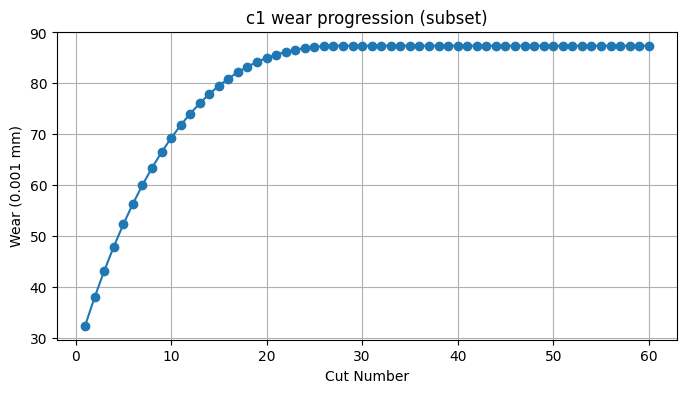

In [9]:
import os, re, glob, numpy as np, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"
c1 = os.path.join(BASE, "c1")

# --- wear we already parsed earlier as df2 with columns ["Cut_Number","Wear_(0.001mm)"]
# If your kernel restarted, re-read it quickly:
wear_file = os.path.join(c1, "c1_wear.csv")
df = pd.read_csv(wear_file, sep=None, engine="python", header=None).dropna(axis=1, how="all")
def to_numeric_series(s):
    if s.dtype.kind in "iufc": return s
    return pd.to_numeric(s.astype(str).str.extract(r"(-?\d+\.?\d*)", expand=False), errors="coerce")
num_cols = [col for col in df.columns if to_numeric_series(df[col]).notna().mean()>0.5]
df2 = df[num_cols[:2]].copy()
df2.columns = ["Cut_Number","Wear_(0.001mm)"]
df2["Cut_Number"] = pd.to_numeric(df2["Cut_Number"], errors="coerce").astype("Int64")
df2["Wear_(0.001mm)"] = pd.to_numeric(df2["Wear_(0.001mm)"], errors="coerce").astype(float)
df2 = df2.dropna()

print("Wear rows:", len(df2), "Cuts range:", int(df2["Cut_Number"].min()), "to", int(df2["Cut_Number"].max()))

# --- 1) Find cut files RECURSIVELY and parse cut number from name
all_csvs = glob.glob(os.path.join(c1, "**", "*.csv"), recursive=True)
all_csvs = [p for p in all_csvs if os.path.abspath(p) != os.path.abspath(wear_file)]

# patterns to try for extracting the cut number
regexes = [
    re.compile(r"c[_-]?1[_-]?(\d+)\.csv$", re.IGNORECASE),  # c_1_305.csv or c1-305.csv
    re.compile(r"c[_-]?(\d+)\.csv$", re.IGNORECASE),        # c_305.csv
    re.compile(r"(\d+)\.csv$", re.IGNORECASE),              # 305.csv
]

cut_paths = []
for p in all_csvs:
    base = os.path.basename(p)
    cut_num = None
    for rgx in regexes:
        m = rgx.search(base)
        if m:
            cut_num = int(m.group(1))
            break
    if cut_num is not None:
        cut_paths.append((cut_num, p))

cut_paths = sorted(cut_paths, key=lambda x: x[0])

print("Found cut CSVs:", len(cut_paths))
print("First 5:", [os.path.basename(p) for _, p in cut_paths[:5]])
print("Last 5:", [os.path.basename(p) for _, p in cut_paths[-5:]])

# --- 2) Feature extractor
def extract_features(signal_df):
    feats = {}
    for col in signal_df.columns:
        x = signal_df[col].to_numpy()
        feats[f"{col}_mean"] = float(np.mean(x))
        feats[f"{col}_std"]  = float(np.std(x))
        feats[f"{col}_rms"]  = float(np.sqrt(np.mean(x**2)))
        feats[f"{col}_max"]  = float(np.max(x))
    return feats

# --- 3) Build a small sanity-set first (to be fast)
MAX_CUTS = 60   # we’ll expand after we confirm it works
picked = cut_paths[:MAX_CUTS]

rows = []
for cut_num, path in tqdm(picked, desc="Extracting features"):
    df_cut = pd.read_csv(path, header=None, engine="c", low_memory=False)
    df_cut = df_cut.dropna(axis=1, how="all")
    if df_cut.shape[1] < 7:
        # skip odd files
        continue
    df_cut = df_cut.iloc[:, :7]
    df_cut.columns = ["Force_X","Force_Y","Force_Z","Vib_X","Vib_Y","Vib_Z","AE_RMS"]
    feats = extract_features(df_cut)
    feats["Cut_Number"] = cut_num
    # attach wear if we have it
    wr = df2.loc[df2["Cut_Number"] == cut_num]
    feats["Wear"] = float(wr["Wear_(0.001mm)"].iloc[0]) if len(wr) else np.nan
    rows.append(feats)

features_df = pd.DataFrame(rows)
print("\nFeatures shape:", features_df.shape)
print(features_df.head())

have_wear = features_df["Wear"].notna().sum() if "Wear" in features_df.columns else 0
no_wear   = len(features_df) - have_wear
print("Cuts with wear label:", have_wear)
print("Cuts without wear:", no_wear)

# --- 4) Quick wear-curve (if we have labels)
if have_wear > 2:
    valid = features_df.dropna(subset=["Wear"]).sort_values("Cut_Number")
    plt.figure(figsize=(8,4))
    plt.plot(valid["Cut_Number"], valid["Wear"], marker="o")
    plt.xlabel("Cut Number"); plt.ylabel("Wear (0.001 mm)"); plt.title("c1 wear progression (subset)")
    plt.grid(True); plt.show()
else:
    print("Not enough labeled cuts yet to plot.")


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# X = features (drop Cut_Number and Wear), y = wear
X = features_df.drop(columns=["Cut_Number", "Wear"])
y = features_df["Wear"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (48, 28) Test size: (12, 28)


In [11]:
# train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)

# evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE = {rmse:.2f}, R² = {r2:.3f}")


RMSE = 4.87, R² = 0.913


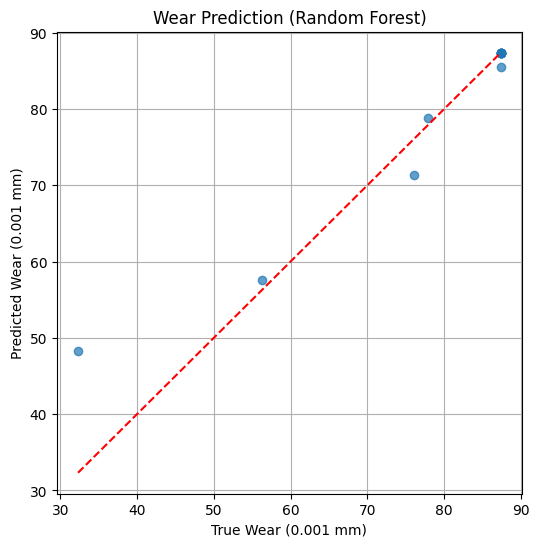

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("True Wear (0.001 mm)")
plt.ylabel("Predicted Wear (0.001 mm)")
plt.title("Wear Prediction (Random Forest)")
plt.grid(True)
plt.show()
